In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-17 09:09:18.604547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750131558.615943   30736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750131558.619103   30736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 09:09:18.629858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/02-paperhybrid-word-spken-paper(ablation)/10-words/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:01<00:00, 320.56it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set parameters for data splitting and training
TEST_SIZE = 0.2
RANDOM_STATE = 42  # For reproducibility

# Encode Labels (from strings to integers)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels
encoded_labels = tf.one_hot(indices=integer_labels, depth=len(label_encoder.classes_))

from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    encoded_labels.numpy(), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=integer_labels  # Stratify ensures balanced splits for each class
)


print("Train, validation, and test data prepared successfully.")


I0000 00:00:1750131570.411926   30736 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10281 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1


Train, validation, and test data prepared successfully.


In [4]:
features[1].shape

(32, 128)


✅ Random Forest Overall Accuracy: 0.7025

📊 Metrics for class 'Akh' (RF):
Precision: 0.6988
Recall: 0.8056
F1-Score: 0.7484
Support: 72.0

📊 Metrics for class 'Zie' (RF):
Precision: 0.6267
Recall: 0.6528
F1-Score: 0.6395
Support: 72.0

📊 Metrics for class 'Thrre' (RF):
Precision: 0.5493
Recall: 0.5342
F1-Score: 0.5417
Support: 73.0

📊 Metrics for class 'Tsor' (RF):
Precision: 0.6250
Recall: 0.6164
F1-Score: 0.6207
Support: 73.0

📊 Metrics for class 'Pancs' (RF):
Precision: 0.5972
Recall: 0.5890
F1-Score: 0.5931
Support: 73.0

📊 Metrics for class 'Shae' (RF):
Precision: 0.7121
Recall: 0.6528
F1-Score: 0.6812
Support: 72.0

📊 Metrics for class 'Sath' (RF):
Precision: 0.7848
Recall: 0.8493
F1-Score: 0.8158
Support: 73.0

📊 Metrics for class 'Eahght' (RF):
Precision: 0.8000
Recall: 0.8219
F1-Score: 0.8108
Support: 73.0

📊 Metrics for class 'Nav' (RF):
Precision: 0.8281
Recall: 0.7361
F1-Score: 0.7794
Support: 72.0

📊 Metrics for class 'Daah' (RF):
Precision: 0.8116
Recall: 0.7671
F1-Score

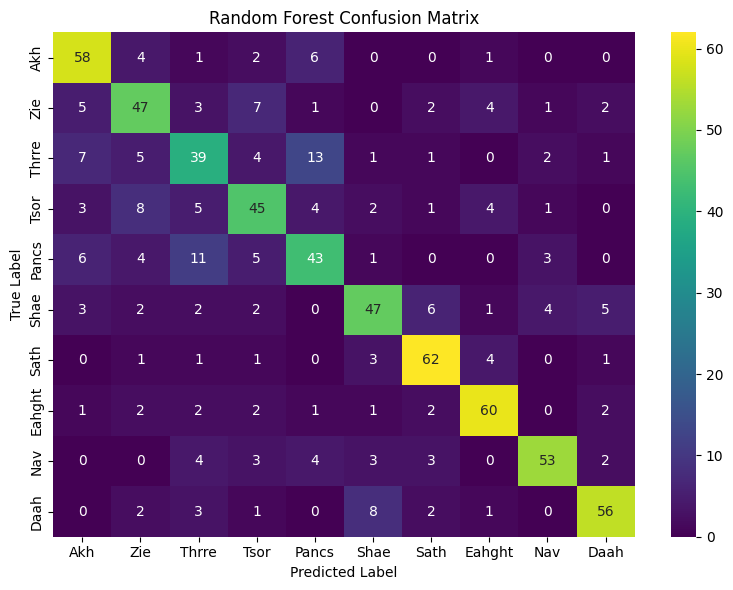

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Class labels
custom_ticks = ['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', 'Shae', 'Sath', 'Eahght', 'Nav', 'Daah']

# Step 1: Flatten the Mel-spectrograms
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Convert one-hot labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Step 3: Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model.fit(X_train_flat, y_train_int)

# Step 4: Make predictions
y_pred_rf = rf_model.predict(X_test_flat)

# Step 5: Evaluate
accuracy_rf = accuracy_score(y_test_int, y_pred_rf)
print(f"\n✅ Random Forest Overall Accuracy: {accuracy_rf:.4f}")

report_rf = classification_report(y_test_int, y_pred_rf, target_names=custom_ticks, output_dict=True)

# Step 6: Print class-wise metrics
for class_name in custom_ticks:
    print(f"\n📊 Metrics for class '{class_name}' (RF):")
    print(f"Precision: {report_rf[class_name]['precision']:.4f}")
    print(f"Recall: {report_rf[class_name]['recall']:.4f}")
    print(f"F1-Score: {report_rf[class_name]['f1-score']:.4f}")
    print(f"Support: {report_rf[class_name]['support']}")

# Step 7: Confusion matrix
conf_matrix_rf = confusion_matrix(y_test_int, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='viridis', xticklabels=custom_ticks, yticklabels=custom_ticks)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
